## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# %matplotlib qt
%matplotlib inline

## First Correct the Distortion:
    
Lets remove distortion from the images using camera calibbration matrix and distortion coefficients using chessboard

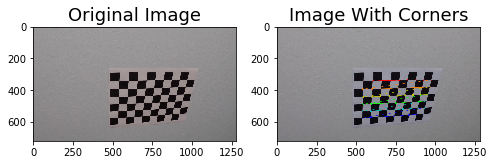

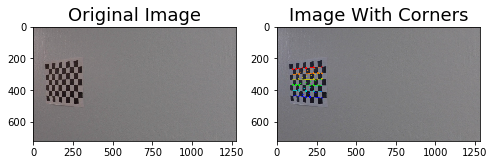

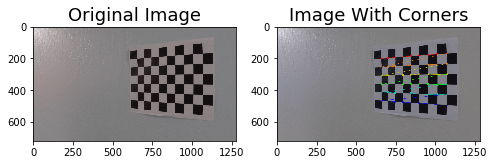

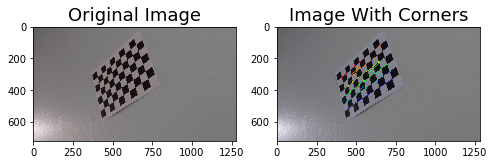

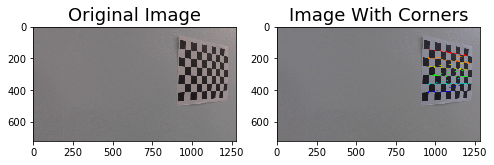

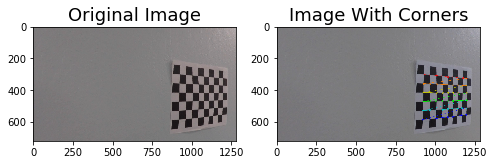

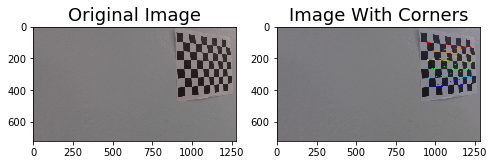

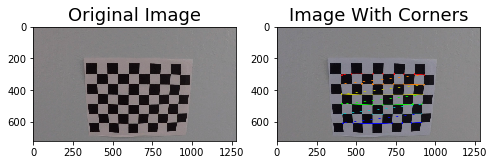

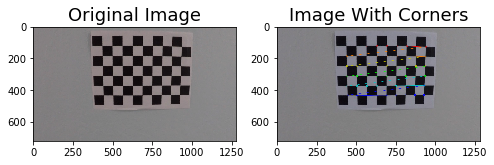

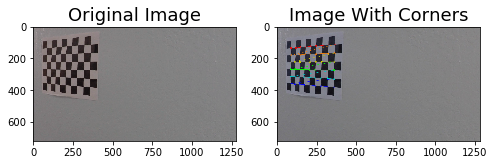

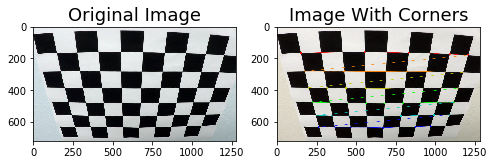

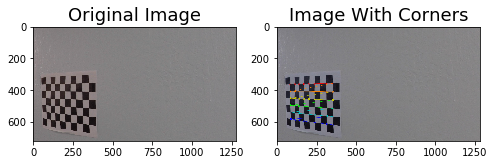

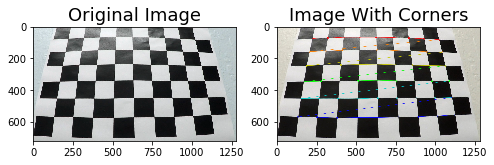

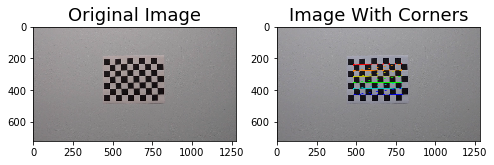

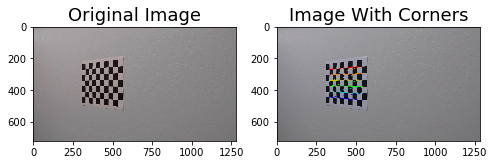

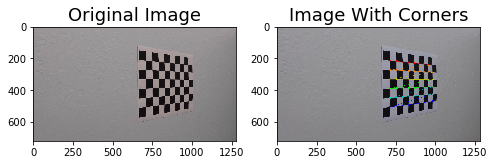

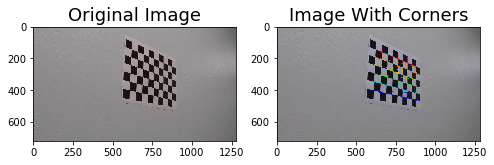

In [2]:


# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
        ax1.imshow(cv2.cvtColor(mpimg.imread(fname), cv2.COLOR_BGR2RGB))
        ax1.set_title('Original Image', fontsize=18)
        ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax2.set_title('Image With Corners', fontsize=18)

#         img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
#         cv2.imshow('img',img)
#         cv2.waitKey(500)

# cv2.destroyAllWindows()

## And so on and so forth...

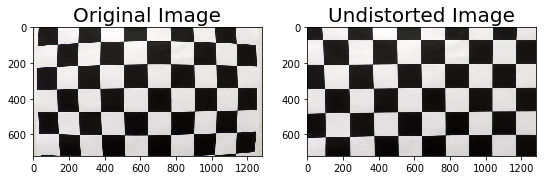

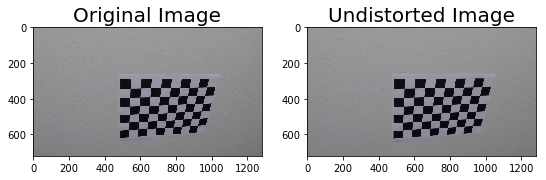

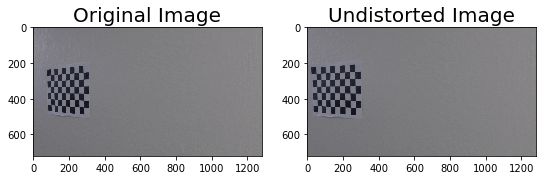

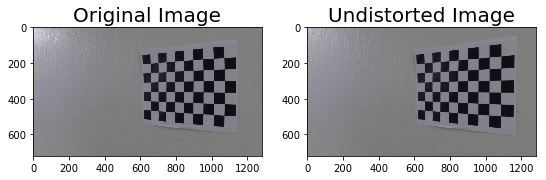

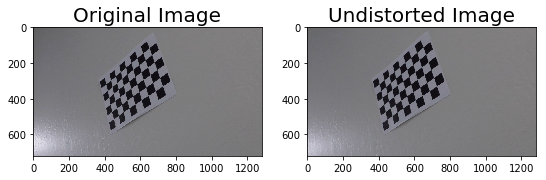

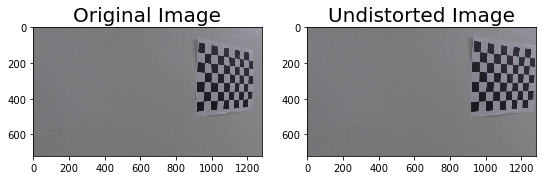

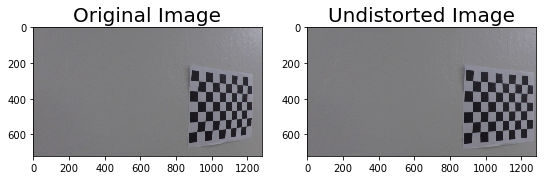

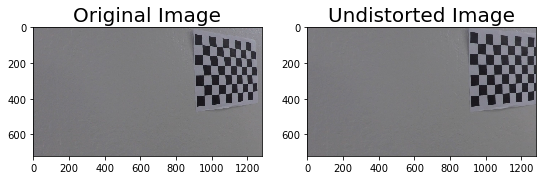

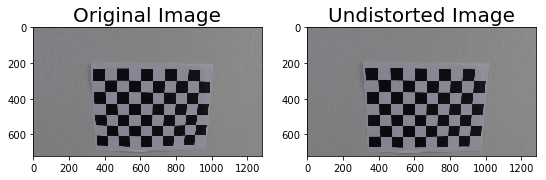

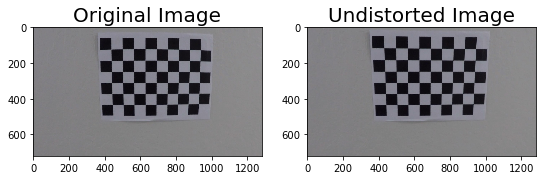

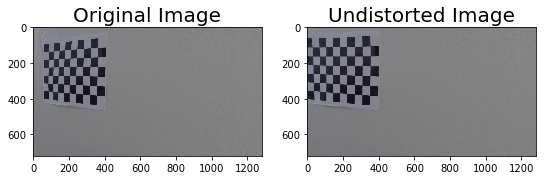

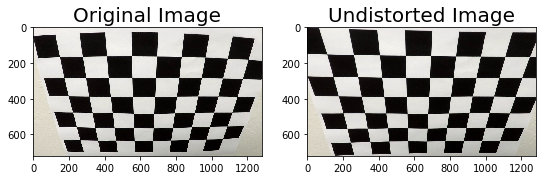

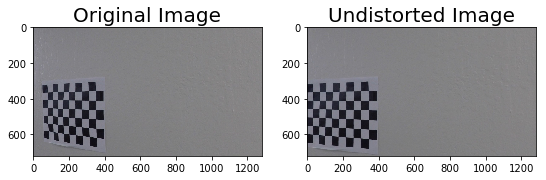

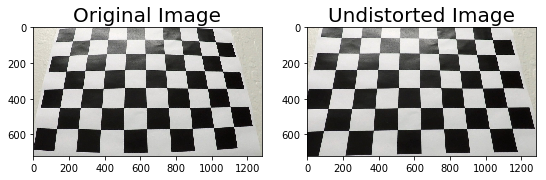

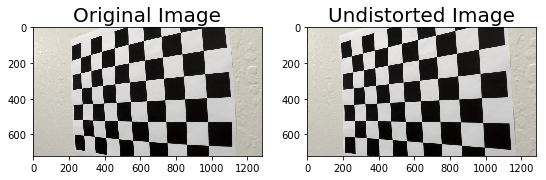

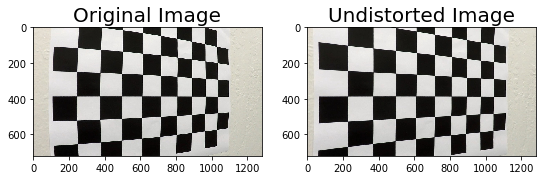

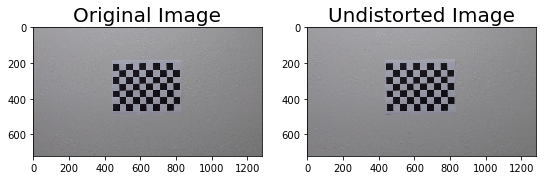

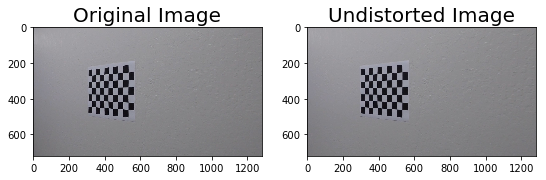

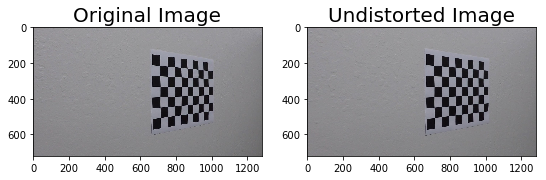

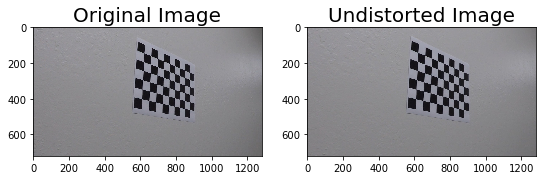

In [3]:
def undistort(image, show=True, read = True): #<---- Use this to remove distortion from the images
    if read:
        img = cv2.imread(image)
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    if show:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,6))
        ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax1.set_title('Original Image', fontsize=20)
        ax2.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
        ax2.set_title('Undistorted Image', fontsize=20)
    else:
        return undist
    
cameraimages = glob.glob('./camera_cal/calibration*.jpg')
for image in cameraimages:
    undistort(image)

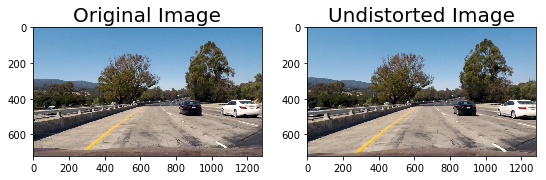

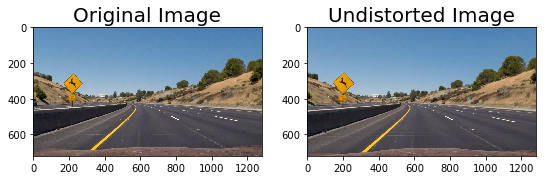

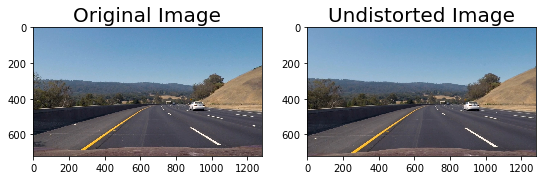

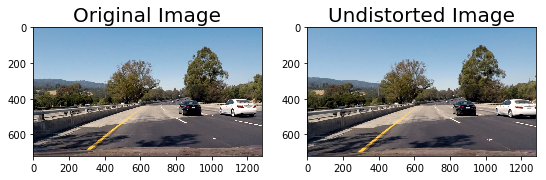

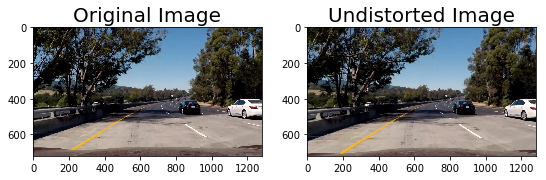

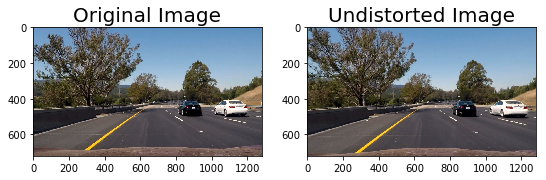

In [4]:
images = glob.glob('./test_images/test*.jpg')
for image in images:
    undistort(image)

## Now lest perfrom the perspective transformation:

Here we will write the code to create Birds eye view:
Why is it important?
To display lane lines relatively parallel to eachother and later fit the polynomial to measure the curevature 

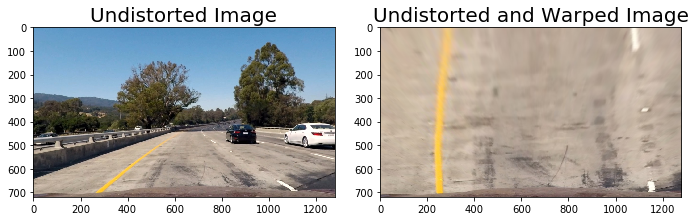

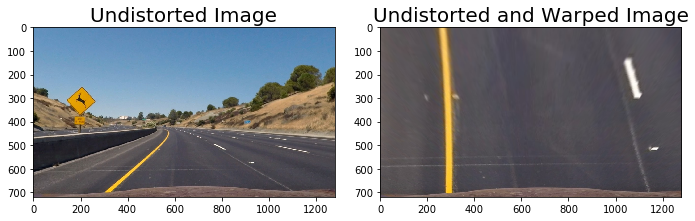

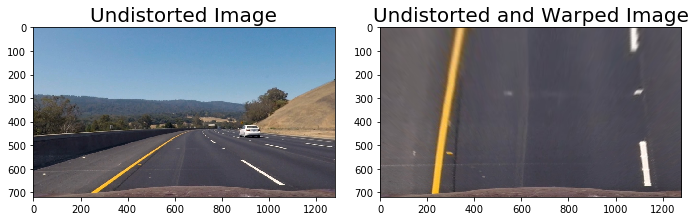

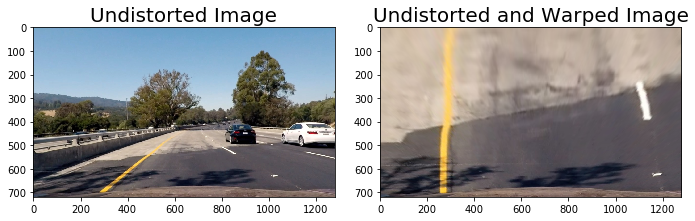

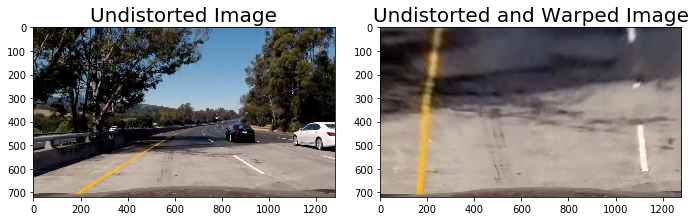

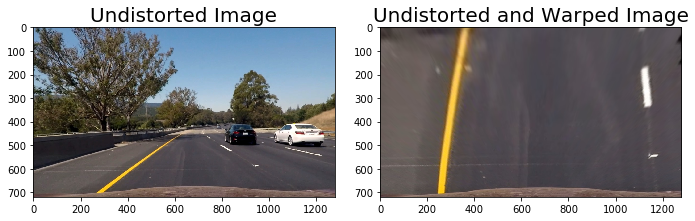

In [5]:
def birds_eye_view(img, display=True, read = True):
    if read:
        undist = undistort(img, show = False)
    else:
        undist = undistort(img, show = False, read=False) 
    img_size = (undist.shape[1], undist.shape[0])
    offset = 0
    src = np.float32([[490, 482],[810, 482],
                      [1300, 720],[40, 720]])
    dst = np.float32([[0, 0], [1280, 0], 
                     [1300, 720],[40, 720]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undist, M, img_size)
    if display:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 6))
        f.tight_layout()
        ax1.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
        ax1.set_title('Undistorted Image', fontsize=20)
        ax2.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
        ax2.set_title('Undistorted and Warped Image', fontsize=20)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    else:
        return warped, M

for image in glob.glob('./test_images/test*.jpg'):
    birds_eye_view(image)

## Lets see what happend when we apply Binary Thresholds

Here we try to apply different color space and identify which provides better lane lines and ignore the onces which give some noise

Used S channel from HLS color space

Used L channel from LUV color space

Used B channel from Lab color space

Create combination binary threshold which best highlights lane lines

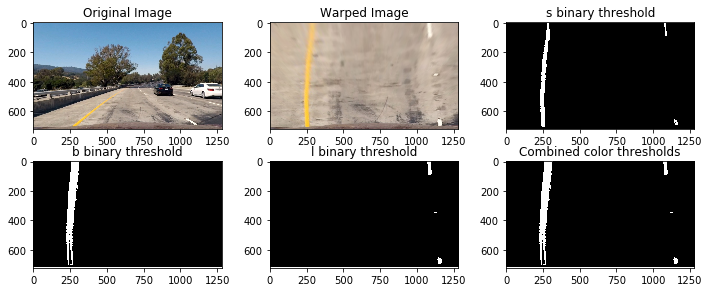

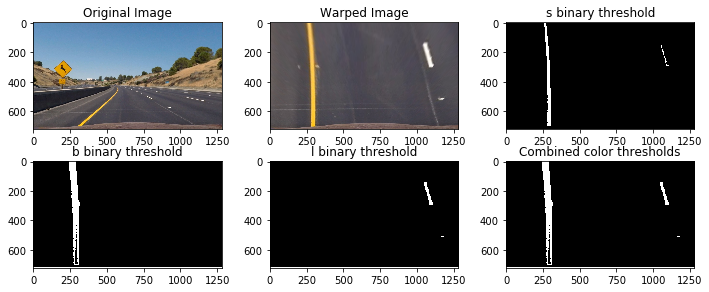

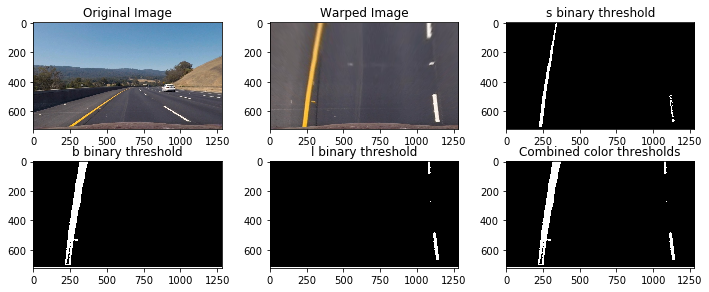

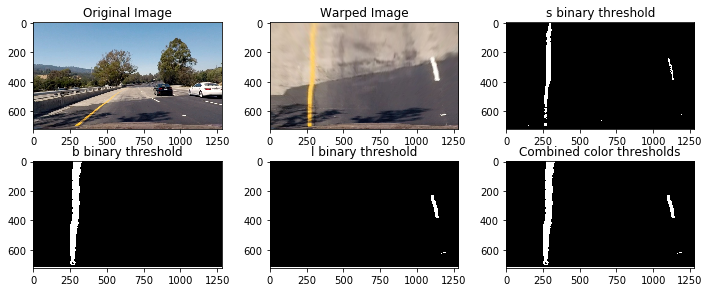

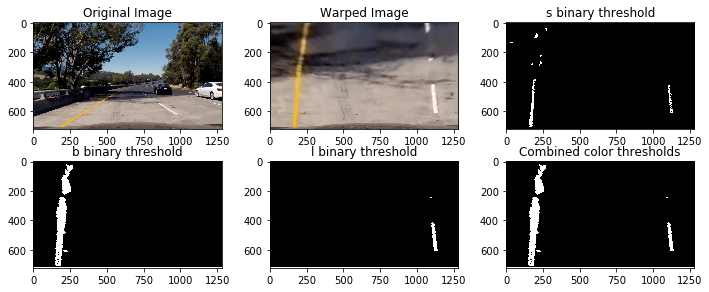

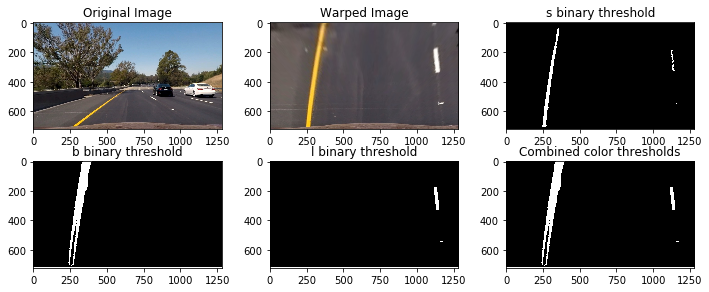

In [6]:
def apply_thresholds(image, show=True):
    img, M = birds_eye_view(image, display = False)

    s_channel = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)[:,:,2]
    
    l_channel = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)[:,:,0]

    b_channel = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)[:,:,2]   

    # Threshold color channel
    s_thresh_min = 185
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    b_thresh_min = 150
    b_thresh_max = 200
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1
    
    l_thresh_min = 225
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1

    #color_binary = np.dstack((u_binary, s_binary, l_binary))
    
    combined_binary = np.zeros_like(s_binary)
    combined_binary[(l_binary == 1) | (b_binary == 1)] = 1

    if show == True:
        # Plotting thresholded images
        f, ((ax1, ax2, ax3), (ax4,ax5, ax6)) = plt.subplots(2, 3, sharey='col', sharex='row', figsize=(10,4))
        f.tight_layout()
        
        ax1.set_title('Original Image', fontsize=12)
        ax1.imshow(cv2.cvtColor(undistort(image, show=False),cv2.COLOR_BGR2RGB))
        
        ax2.set_title('Warped Image', fontsize=12)
        ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype('uint8'))
        
        ax3.set_title('s binary threshold', fontsize=12)
        ax3.imshow(s_binary, cmap='gray')
        
        ax4.set_title('b binary threshold', fontsize=12)
        ax4.imshow(b_binary, cmap='gray')
        
        ax5.set_title('l binary threshold', fontsize=12)
        ax5.imshow(l_binary, cmap='gray')

        ax6.set_title('Combined color thresholds', fontsize=12)
        ax6.imshow(combined_binary, cmap='gray')
        
        
    else: 
        return combined_binary
    
for image in glob.glob('./test_images/test*.jpg'):
    apply_thresholds(image)

## After finding combination of the binary threshold which gives the best result, lets try to Fit a polynomial to the lane line and find vehicle position and Radius of Curvature

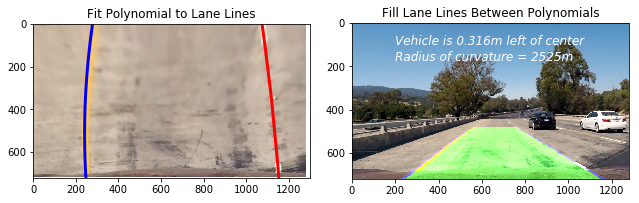

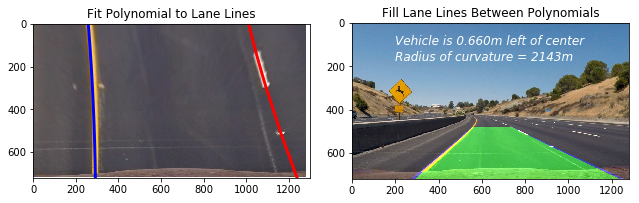

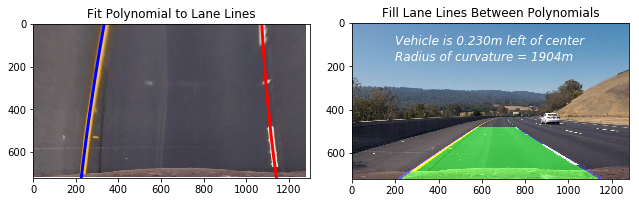

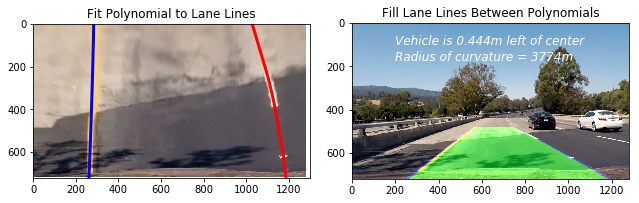

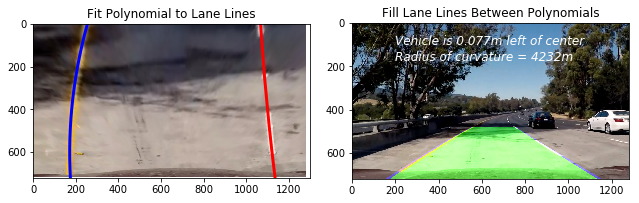

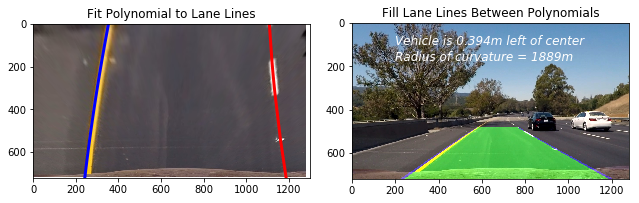

In [7]:
def fill_lane_lines(image):
    
    combined_binary = apply_thresholds(image, show=False)
    
    rightx = []
    righty = []
    leftx = []
    lefty = []
    
    x, y = np.nonzero(np.transpose(combined_binary))
    i = 720
    j = 630
    while j >= 0:
        histogram = np.sum(combined_binary[j:i,:], axis=0)
        left_peak = np.argmax(histogram[:640])
        x_idx = np.where((((left_peak - 25) < x)&(x < (left_peak + 25))&((y > j) & (y < i))))
        x_window, y_window = x[x_idx], y[x_idx]
        if np.sum(x_window) != 0:
            leftx.extend(x_window.tolist())
            lefty.extend(y_window.tolist())

        right_peak = np.argmax(histogram[640:]) + 640
        x_idx = np.where((((right_peak - 25) < x)&(x < (right_peak + 25))&((y > j) & (y < i))))
        x_window, y_window = x[x_idx], y[x_idx]
        if np.sum(x_window) != 0:
            rightx.extend(x_window.tolist())
            righty.extend(y_window.tolist())
        i -= 90
        j -= 90

    lefty = np.array(lefty).astype(np.float32)
    leftx = np.array(leftx).astype(np.float32)
    righty = np.array(righty).astype(np.float32)
    rightx = np.array(rightx).astype(np.float32)
    left_fit = np.polyfit(lefty, leftx, 2)
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    right_fit = np.polyfit(righty, rightx, 2)
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
    rightx_int = right_fit[0]*720**2 + right_fit[1]*720 + right_fit[2]
    rightx = np.append(rightx,rightx_int)
    righty = np.append(righty, 720)
    rightx = np.append(rightx,right_fit[0]*0**2 + right_fit[1]*0 + right_fit[2])
    righty = np.append(righty, 0)
    leftx_int = left_fit[0]*720**2 + left_fit[1]*720 + left_fit[2]
    leftx = np.append(leftx, leftx_int)
    lefty = np.append(lefty, 720)
    leftx = np.append(leftx,left_fit[0]*0**2 + left_fit[1]*0 + left_fit[2])
    lefty = np.append(lefty, 0)
    lsort = np.argsort(lefty)
    rsort = np.argsort(righty)
    lefty = lefty[lsort]
    leftx = leftx[lsort]
    righty = righty[rsort]
    rightx = rightx[rsort]
    left_fit = np.polyfit(lefty, leftx, 2)
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    right_fit = np.polyfit(righty, rightx, 2)
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
    
    # For each lane line measure radius of curvature
    ym_per_pix = 15/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/1000 # meteres per pixel in x dimension
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    left_curverad = ((1 + (2*left_fit_cr[0]*np.max(lefty) + left_fit_cr[1])**2)**1.5) \
                                 /np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*np.max(lefty) + right_fit_cr[1])**2)**1.5) \
                                    /np.absolute(2*right_fit_cr[0])
    
    
    # Calculate the position of the vehicle
    center = abs(640 - ((rightx_int+leftx_int)/2))
    
    offset = 0 
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([[490, 482],[810, 482],
                      [1300, 720],[40, 720]])
    dst = np.float32([[0, 0], [1280, 0], 
                     [1300, 720],[40, 720]])
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warp_zero = np.zeros_like(combined_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.flipud(np.transpose(np.vstack([left_fitx, lefty])))])
    pts_right = np.array([np.transpose(np.vstack([right_fitx, righty]))])
    pts = np.hstack((pts_left, pts_right))
    cv2.polylines(color_warp, np.int_([pts]), isClosed=False, color=(0,0,255), thickness = 40)
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp = cv2.warpPerspective(color_warp, Minv, (combined_binary.shape[1], combined_binary.shape[0]))
    result = cv2.addWeighted(mpimg.imread(image), 1, newwarp, 0.5, 0)
    
    f, (ax1, ax2) = plt.subplots(1,2, figsize=(9, 6))
    f.tight_layout()
    ax1.imshow(cv2.cvtColor((birds_eye_view(image, display=False)[0]), cv2.COLOR_BGR2RGB))
    ax1.set_xlim(0, 1300)
    ax1.set_ylim(0, 720)
    ax1.plot(left_fitx, lefty, color='blue', linewidth=3)
    ax1.plot(right_fitx, righty, color='red', linewidth=3)
    ax1.set_title('Fit Polynomial to Lane Lines', fontsize=12)
    ax1.invert_yaxis() # to visualize as we do the images
    ax2.imshow(result)
    ax2.set_title('Fill Lane Lines Between Polynomials', fontsize=12)
    if center < 700:
        ax2.text(200, 100, 'Vehicle is {:.3f}m left of center'.format(center*3.7/700),
                 style='italic', color='white', fontsize=12)
    else:
        ax2.text(200, 100, 'Vehicle is {:.3f}m right of center'.format(center*3.7/700),
                 style='italic', color='white', fontsize=12)
    ax2.text(200, 175, 'Radius of curvature = {}m'.format(int((left_curverad + right_curverad)/2)),
             style='italic', color='white', fontsize=12)
    
for image in glob.glob('./test_images/test*.jpg'):
    fill_lane_lines(image)
    

## Now we have estimation of radius of curvature and position of the vehicle 
## Lets create video processing pipeline by using class line() for storing the lane line attributes 

In [8]:
class Line:
    def __init__(self):
        
        self.found = False
        
        # Remember x and y values of lanes in previous frame
        self.X = None
        self.Y = None
        
        # Store recent x intercepts for averaging across frames
        self.x_int = deque(maxlen=20)
        self.top = deque(maxlen=20)
        
        # Remember previous x intercept to compare against current one
        self.lastx_int = None
        self.last_top = None
        
        # Remember radius of curvature
        self.radius = None
        
        # Store recent polynomial coefficients for averaging across frames
        self.fit0 = deque(maxlen=20)
        self.fit1 = deque(maxlen=20)
        self.fit2 = deque(maxlen=20)
        self.fitx = None
        self.pts = []
        
        # Count the number of frames
        self.count = 0
        
    def f_search(self, x, y):
        
        xevals = []
        yevals = []
        if self.found == True: 
            i = 720
            j = 630
            while j >= 0:
                yeval = np.mean([i,j])
                xeval = (np.mean(self.fit0))*yeval**2 + (np.mean(self.fit1))*yeval + (np.mean(self.fit2))
                x_idx = np.where((((xeval - 25) < x)&(x < (xeval + 25))&((y > j) & (y < i))))
                x_window, y_window = x[x_idx], y[x_idx]
                if np.sum(x_window) != 0:
                    np.append(xevals, x_window)
                    np.append(yevals, y_window)
                i -= 90
                j -= 90
        if np.sum(xevals) == 0: 
            self.found = False # perform blind search icase of no lines found or other temp. sol. you can try to return image
        return xevals, yevals, self.found
    
    def b_search(self, x, y, image):
        
        xevals = []
        yevals = []
        if self.found == False: 
            i = 720
            j = 630
            while j >= 0:
                histogram = np.sum(image[j:i,:], axis=0)
                if self == Right:
                    peak = np.argmax(histogram[640:]) + 640
                else:
                    peak = np.argmax(histogram[:640])
                x_idx = np.where((((peak - 25) < x)&(x < (peak + 25))&((y > j) & (y < i))))
                x_window, y_window = x[x_idx], y[x_idx]
                if np.sum(x_window) != 0:
                    xevals.extend(x_window)
                    yevals.extend(y_window)
                i -= 90
                j -= 90
        if np.sum(xevals) > 0:
            self.found = True
        else:
            yevals = self.Y
            xevals = self.X
        return xevals, yevals, self.found
    
    def radius_of_curvature(self, xevals, yevals):
        ym_per_pix = 15/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/1000 # meteres per pixel in x dimension
        fit_cr = np.polyfit(yevals*ym_per_pix, xevals*xm_per_pix, 2)
        curverad = ((1 + (2*fit_cr[0]*np.max(yevals) + fit_cr[1])**2)**1.5) \
                                     /np.absolute(2*fit_cr[0])
        return curverad
    
    def sort_evals(self, xevals, yevals):
        sorted_index = np.argsort(yevals)
        sorted_yevals = yevals[sorted_index]
        sorted_xevals = xevals[sorted_index]
        return sorted_xevals, sorted_yevals
    
    def get_intercepts(self, polynomial):
        bottom = polynomial[0]*720**2 + polynomial[1]*720 + polynomial[2]
        top = polynomial[0]*0**2 + polynomial[1]*0 + polynomial[2]
        return bottom, top

## Lets create function process_video() which will process video frame by frame:

In [9]:
def process_video(image):
    img_size = (image.shape[1], image.shape[0])
    
    # Calibrate camera and undistort image
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    
    # Perform perspective transform
    offset = 0
    src = np.float32([[490, 482],[810, 482],
                      [1300, 720],[0, 720]])
    dst = np.float32([[0, 0], [1280, 0], 
                     [1300, 720],[40, 720]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undist, M, img_size)
    
    # Ignoring s_channel here and generate binary thresholded images
    b_channel = cv2.cvtColor(warped, cv2.COLOR_RGB2Lab)[:,:,2]
    l_channel = cv2.cvtColor(warped, cv2.COLOR_RGB2LUV)[:,:,0]  
    
    # UL and LL, b channel
    b_thresh_min = 145
    b_thresh_max = 200
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1
    
    # UL and LL, l channel
    l_thresh_min = 215
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1

    combined_binary = np.zeros_like(b_binary)
    combined_binary[(l_binary == 1) | (b_binary == 1)] = 1
    
    # Identify all non zero pixels in the image
    x, y = np.nonzero(np.transpose(combined_binary)) 

    if Left.found == True: # look for left lane pixels around previous polynomial
        leftx, lefty, Left.found = Left.f_search(x, y)
        
    if Right.found == True: # look for right lane pixels around previous polynomial
        rightx, righty, Right.found = Right.f_search(x, y)

            
    if Right.found == False: # Perform blind search for right lane lines
        rightx, righty, Right.found = Right.b_search(x, y, combined_binary)
            
    if Left.found == False:# Perform blind search for left lane lines
        leftx, lefty, Left.found = Left.b_search(x, y, combined_binary)

    lefty = np.array(lefty).astype(np.float32)
    leftx = np.array(leftx).astype(np.float32)
    righty = np.array(righty).astype(np.float32)
    rightx = np.array(rightx).astype(np.float32)
            
    
    left_fit = np.polyfit(lefty, leftx, 2)
    
    
    leftx_int, left_top = Left.get_intercepts(left_fit)
    
    # Average intercepts across n frames
    Left.x_int.append(leftx_int)
    Left.top.append(left_top)
    leftx_int = np.mean(Left.x_int)
    left_top = np.mean(Left.top)
    Left.lastx_int = leftx_int
    Left.last_top = left_top
    
    # Adding averaged intercepts to current x and y evals
    leftx = np.append(leftx, leftx_int)
    lefty = np.append(lefty, 720)
    leftx = np.append(leftx, left_top)
    lefty = np.append(lefty, 0)
    
    # Sort detected pixels based on the yevals
    leftx, lefty = Left.sort_evals(leftx, lefty)
    
    Left.X = leftx
    Left.Y = lefty
    
    # Recalculate polynomial with intercepts and average across n frames
    left_fit = np.polyfit(lefty, leftx, 2)
    Left.fit0.append(left_fit[0])
    Left.fit1.append(left_fit[1])
    Left.fit2.append(left_fit[2])
    left_fit = [np.mean(Left.fit0), 
                np.mean(Left.fit1), 
                np.mean(Left.fit2)]
    
    
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    Left.fitx = left_fitx
    
    
    right_fit = np.polyfit(righty, rightx, 2)

    
    rightx_int, right_top = Right.get_intercepts(right_fit)
    
    # Average intercepts across 5 frames
    Right.x_int.append(rightx_int)
    rightx_int = np.mean(Right.x_int)
    Right.top.append(right_top)
    right_top = np.mean(Right.top)
    Right.lastx_int = rightx_int
    Right.last_top = right_top
    rightx = np.append(rightx, rightx_int)
    righty = np.append(righty, 720)
    rightx = np.append(rightx, right_top)
    righty = np.append(righty, 0)
    
    # Sort right lane pixels
    rightx, righty = Right.sort_evals(rightx, righty)
    Right.X = rightx
    Right.Y = righty
    
    # Recalculate polynomial with intercepts and average across n frames
    right_fit = np.polyfit(righty, rightx, 2)
    Right.fit0.append(right_fit[0])
    Right.fit1.append(right_fit[1])
    Right.fit2.append(right_fit[2])
    right_fit = [np.mean(Right.fit0), np.mean(Right.fit1), np.mean(Right.fit2)]
    
    # Fit polynomial to detected pixels
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
    Right.fitx = right_fitx
        
   
    left_curverad = Left.radius_of_curvature(leftx, lefty)
    right_curverad = Right.radius_of_curvature(rightx, righty)
        
    # Print the radius of curvature every 3 frames for better readability
    if Left.count % 3 == 0:
        Left.radius = left_curverad
        Right.radius = right_curverad
        
    # Find vehicle position relative to the center of the lane
    position = (rightx_int+leftx_int)/2
    distance_from_center = abs((640 - position)*3.7/700) 
                
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warp_zero = np.zeros_like(combined_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.flipud(np.transpose(np.vstack([Left.fitx, Left.Y])))])
    pts_right = np.array([np.transpose(np.vstack([right_fitx, Right.Y]))])
    pts = np.hstack((pts_left, pts_right))
    cv2.polylines(color_warp, np.int_([pts]), isClosed=False, color=(0,0,255), thickness = 40)
    cv2.fillPoly(color_warp, np.int_(pts), (34,255,34))
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))
    result = cv2.addWeighted(undist, 1, newwarp, 0.5, 0)
        
    # Printing distance from center 
    if position > 640:
        cv2.putText(result, 'Vehicle is {:.3f}m left of center'.format(distance_from_center), (100,80),
                 fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 5)
    else:
        cv2.putText(result, 'Vehicle is {:.3f}m right of center'.format(distance_from_center), (100,80),
                 fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 5)
    # Print radius of curvature on video
    cv2.putText(result, 'Radius of Curvature = {}(m)'.format(int((Left.radius+Right.radius)/2)), (120,140),
             fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 5)
    Left.count += 1
    return result

In [10]:
from collections import deque
from moviepy.editor import VideoFileClip

Left = Line()
Right = Line()
video_output = './output_video/result.mp4'
clip1 = VideoFileClip("./project_video.mp4").subclip(0,50)
white_clip = clip1.fl_image(process_video) 
white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video ./output_video/result.mp4
[MoviePy] Writing video ./output_video/result.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1250/1251 [23:22<00:01,  1.12s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_video/result.mp4 



In [11]:
from IPython.display import HTML
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('./output_video/result.mp4'))

In [12]:
video_output = './output_video/challengeresult.mp4'
clip1 = VideoFileClip("./challenge_video.mp4").subclip(0,10)
white_clip = clip1.fl_image(process_video) 
white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video ./output_video/challengeresult.mp4
[MoviePy] Writing video ./output_video/challengeresult.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [05:28<00:00,  1.09s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_video/challengeresult.mp4 



In [13]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('./output_video/challengeresult.mp4'))

In [17]:
# video_output = './output_video/harderchallengeresult.mp4'
# clip1 = VideoFileClip("harder_challenge_video.mp4").subclip(0,5)
# white_clip = clip1.fl_image(process_video) 
# white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video ./output_video/harderchallengeresult.mp4
[MoviePy] Writing video ./output_video/harderchallengeresult.mp4


 99%|███████████████████████████████████████████████████████████████████████████████▎| 125/126 [02:30<00:01,  1.17s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_video/harderchallengeresult.mp4 



In [18]:
# HTML("""
# <video width="640" height="360" controls>
#   <source src="{0}">
# </video>
# """.format('./output_video/harderchallengeresult.mp4'))